# Программирование на Python
## Семинар 8. Python для анализа данных
#### Задача 1
Вам дан массив данных, представленный в виде списка списков. Каждый вложенный список представляет собой измерение одного параметра для разных индивидуумов. В процессе обработки данных вам часто придется сталкиваться с тем, что параметры могут иметь разную шкалу. Существуют различные способы решения данной проблемы, среди которых - т. н. стандартизация, приводящее значения к стандартному нормальному распределению (большинство значений от -3 до 3). Формула выглядит следующим образом (в данном случае `x` - каждое значение, т. е. операцию ниже необходимо выполнить с каждым значением наших данных):

![standardization](https://i.ibb.co/THbWKqM/1-YSAAU-v-I8-Ol-HQz-G5-A1-Sg.png)

Напишите функцию, которая выполняет эту стандартизацию для двухмерного массива. При этом должна быть предусмотрена возможность осуществить это по строкам, по колонкам и для всего массива в целом.

Решите задачу в двух вариантах: 1) используя ТОЛЬКО встроенные средства Python и 2) с помощью `numpy`. Сравните эффективность двух подходов.

In [5]:
np.random.uniform()

0.1642088554777109

In [6]:
import numpy as np

# (псевдо)случайно генерируем матрицу 10 * 10000 из равномерного распределения с границами от -1000 до 1000
simulated_data = np.random.uniform(-1000, 1000, (10, 10000))
simulated_data_list = simulated_data.tolist()

**Python**

In [7]:
def mean(vector):
    return sum(vector) / len(vector)

def std(vector):
    vector_mean = mean(vector)
    vector_std = (sum((x - vector_mean) ** 2 for x in vector) / len(vector)) ** (1 / 2)

    return vector_std

def standardize1d(vector):
    vector_mean = mean(vector)
    vector_sd = std(vector)
    vector_std = [(x - vector_mean) / vector_sd for x in vector]

    return vector_std

def standardize(matrix):
    return [standardize1d(vector) for vector in matrix]

In [8]:
simulated_data_list_sd = standardize(simulated_data_list)

In [9]:
%%timeit
simulated_data_list_sd = standardize(simulated_data_list)

8.98 ms ± 36.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**NumPy**

In [28]:
%%timeit
nrows = simulated_data.shape[0]

means = simulated_data.mean(axis=1).reshape((nrows, 1))
stds = simulated_data.std(axis=1).reshape((nrows, 1))

simulated_data_sd = (simulated_data - means) / stds

167 µs ± 1.33 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Задача 2
Используя средства numpy, проведите вычислительный эксперимент и выясните, можно ли считать статистически значимым результат проверки одной из выдвинутых на прошлом занятии гипотез.

**Data source:** https://www.kaggle.com/datasets/spscientist/students-performance-in-exams.

**Columns:**
- `gender` (binary variable);
- `race/ethnicity` (categorical variable);
- `parental level of education` (categorical variable, student's parents' level of education);
- `lunch` (categorical variable, quality of student's lunch);
- `test preparation course` (categorical variable, whether student managed to complete preparation course for the test);
- `math score` (numeric variable, score for Math test);
- `reading score` (numeric variable, score for Reading part);
- `writing score` (numeric variable, score for Writing part).

In [37]:
import csv
from collections import defaultdict, Counter

def group(vector: list, grouping: list) -> defaultdict:
    grouped = defaultdict(list)

    for v, g in zip(vector, grouping):
        grouped[g].append(v)

    return grouped

path = '../Занятие 1/StudentsPerformance.csv'
int_cols = ['math score', 'reading score', 'writing score']
data = defaultdict(list)

with open(path, mode='r', newline='') as file:
    csvfile = csv.DictReader(file, delimiter=',')

    for dct in csvfile:
        for key, value in dct.items():
            if key in int_cols:
                data[key].append(int(value))
            else:
                data[key].append(value)

In [ ]:
# ВОПРОС: есть ли различия в результатах сдачи теста по математике в зависимости от уровня образования родителей

# math score
# parental level of education

In [45]:
education_mapper = {
    'some college': 'higher',
    "associate's degree": 'higher',
    'high school': 'not higher',
    'some high school': 'not higher',
    "bachelor's degree": 'higher',
    "master's degree": 'higher'
}

data['parental education'] = [education_mapper.get(key) for key in data['parental level of education']]

In [47]:
math_grouped_by_parents = group(data['math score'], data['parental education'])

higher = np.array(math_grouped_by_parents['higher'])
not_higher = np.array(math_grouped_by_parents['not higher'])

In [50]:
real_diff = higher.mean() - not_higher.mean()
real_diff

5.283733333333338

In [51]:
# H0: разницы нет, все случайно

# насколько вероятно получить наблюдаемое значение разности, если на самом деле разницы между группами нет, а все объясняется
# случайными причинами (если H0 верна)

# а какие вообще значения могли бы получаться, если бы разница была исключительно случайной -> найти распределение разницы при условии H0

# такой эксперимент очень сложно провести
# СИМУЛИРОВАТЬ:
#1 объединяем higher и not_higher в один вектор
#2 перемешаем объединенный вектор случайным образом
#3 расцепим его обратно на два исходных вектора
#4 посчитаем разность средних значений - она точно будет случайность
#5 повторить операцию N раз

In [68]:
concat = np.concatenate((higher, not_higher))
permuted = np.random.permutation(concat)

vector1_new, vector2_new = permuted[:higher.size], permuted[higher.size:]

In [69]:
def simulate(vector1, vector2):
    concat = np.concatenate((vector1, vector2))
    permuted = np.random.permutation(concat)
    vector1_new, vector2_new = permuted[:vector1.size], permuted[vector2.size:]
    simulated_diff = vector1_new.mean() - vector2_new.mean()
    
    return simulated_diff

In [70]:
N = 100000

simulated_diffs = np.array([simulate(higher, not_higher) for i in range(N)])

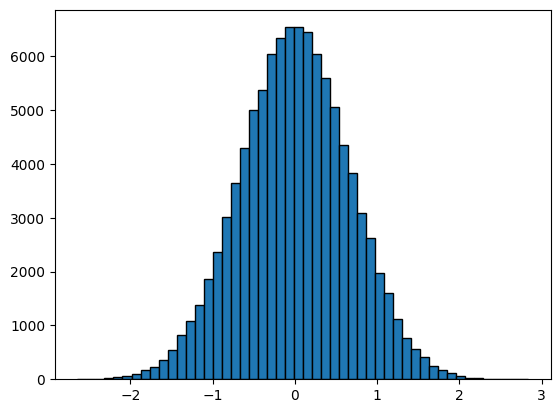

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(simulated_diffs, bins=50, edgecolor='black');

In [74]:
# встретить real_diff (наблюдаемое значение разности) при условии H0 настолько маловероятно, что нам следует отклонить H0
real_diff

5.283733333333338

#### Задача 3
Сделайте данное вам ниже изображение черно-белым.

/var/folders/h6/lv17v1r10lz21g745pd6774h0tgc4z/T/ipykernel_5639/3783902954.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imread('./google_maps.png')


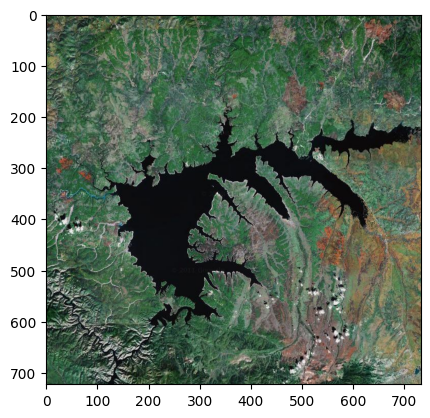

In [75]:
from imageio import imread
import matplotlib.pyplot as plt

img1 = imread('./google_maps.png')
plt.imshow(img1);

In [76]:
img1.shape

(723, 733, 3)

In [77]:
img1[0, 0, :]

array([45, 65, 37], dtype=uint8)

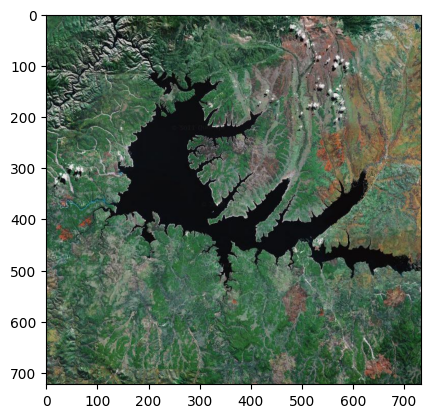

In [80]:
plt.imshow(img1[::-1, :, :]);

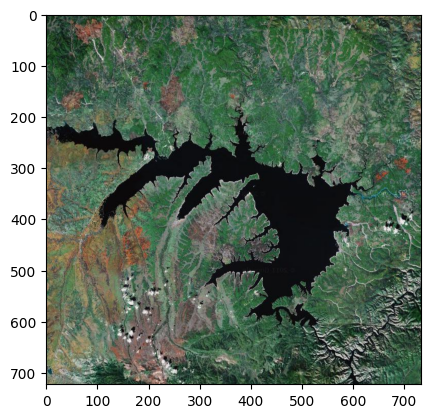

In [81]:
plt.imshow(img1[:, ::-1, :]);

In [82]:
img1[0, 0, :]

array([45, 65, 37], dtype=uint8)

In [83]:
img1.shape

(723, 733, 3)

In [90]:
img1

array([[[ 45,  65,  37],
        [ 76,  96,  68],
        [100, 120,  93],
        ...,
        [ 39,  56,  48],
        [ 26,  43,  35],
        [ 41,  58,  50]],

       [[ 83, 102,  74],
        [ 68,  88,  60],
        [ 76,  94,  68],
        ...,
        [ 41,  58,  50],
        [ 34,  54,  45],
        [ 46,  63,  55]],

       [[ 75,  91,  64],
        [ 97, 116,  88],
        [ 95, 111,  84],
        ...,
        [ 26,  46,  37],
        [ 27,  48,  39],
        [ 53,  73,  64]],

       ...,

       [[ 69,  96,  65],
        [ 69, 100,  69],
        [ 63,  94,  63],
        ...,
        [131, 133, 111],
        [132, 136, 113],
        [141, 143, 119]],

       [[ 75, 101,  74],
        [ 72, 102,  74],
        [ 67,  97,  71],
        ...,
        [117, 121,  96],
        [133, 137, 114],
        [135, 139, 114]],

       [[ 75, 101,  76],
        [ 68,  98,  72],
        [ 77, 107,  83],
        ...,
        [168, 174, 148],
        [155, 161, 135],
        [136, 142, 116]]

In [91]:
means.shape

(723, 733)

In [98]:
(*means.shape, 1)

(723, 733, 1)

In [94]:
means = img1.mean(axis=2).round().astype(int)
image_new = np.repeat(means.reshape((*means.shape, 1)), 3, axis=2)

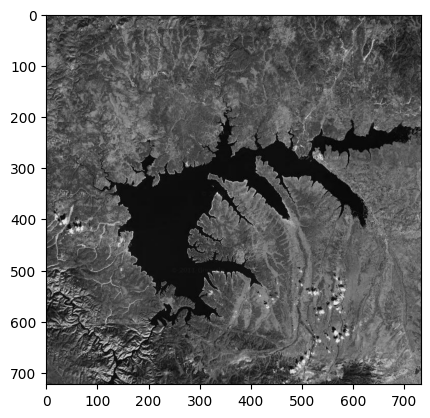

In [96]:
plt.imshow(image_new);